# Modeling and Simulation of a Grocery Store Checkout Operation

Consider a grocery store with muliple checkout lines. Each checkout line is managed by a server, each server with a unique rate at checking items. Let's develop a simulation.

1. What would be the key performance indicators to monitor?
2. What assumptions should we make about customer behavior?
3. What data is needed to describe the objects in each queue?
4. Are all checkout lanes the same?
5. How can we set up this simulation?

In [58]:
!pip install simpy

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import simpy
import pandas as pd

## Basic Model

The following sections build this grocery store model a piece at a time. We begin with checkout lanes, then add customers, then logging functions to gather and report results, and finally complete the model by adding a server for each checkout lane. 

The basic model incorporates a number of assumptions about customer behavior. At the end of this section are exercises asking to you extend the model by refining these assumptions. Take your bes shot at these, and be ready to discuss during the next class session.

### Model checkout lanes as SimPy.Store() resources

We can start the model development with a definition of check out lanes. For now assume the checkout lanes can be modeled as SimPy.Store shared resources. These are stored in a list called `lanes` which are indexed as 0, 1, ..., N-1 where $N$ is the number of lanes.

In [64]:
# time units = minutes

# number of checkout lanes
N = 4

# create simulation
env = simpy.Environment()

# checkout lanes modeled as SimPy Stores
lanes = [simpy.Store(env) for n in range(N)]

# run simulation
env.run(until = 60)

### Modeling customer behavior

The next step is to create customers. For the purpose, we write a Python generator that accepts a rate argument specifying the rate at which customers approach the checkout lanes. Each customer carries a cart with a number of items. The number of items is random integer.

In [65]:
# time units = minutes

# number of checkout lanes
N = 4

# customer generator, assign to random checkout lane
def customer_generator(rate=1.0):
    customer_id = 1
    while True:
        yield env.timeout(random.expovariate(rate))
        n_cart_items = random.randint(1, 25)
        lane_number = random.randint(0, N-1)
        yield lanes[lane_number].put([customer_id, n_cart_items, env.now])
        customer_id += 1

# create simulation
env = simpy.Environment()

# checkout lanes modeled as SimPy Stores
lanes = [simpy.Store(env) for n in range(N)]

# create processes
env.process(customer_generator())

# run simulation
env.run(until=60)

### Monitoring of checkout lanes

At this point we have a working simulation, but no way to see the results. The next cell adds a monitoring process that records the length of all checkout lanes. The collected data is plotted when the simulation is complete.

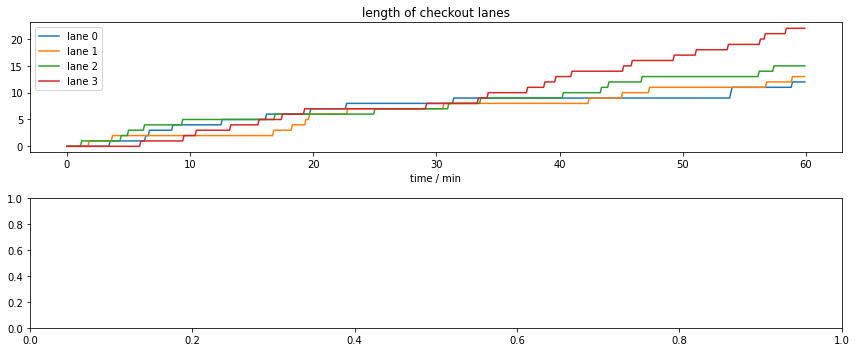

In [66]:
# time units = minutes

# number of checkout lanes
N = 4

# customer generator, assign to random checkout lane
def customer_generator(rate=1.0):
    customer_id = 1
    while True:
        yield env.timeout(random.expovariate(rate))
        n_cart_items = random.randint(1, 25)
        lane_number = random.randint(0, N-1)
        yield lanes[lane_number].put([customer_id, n_cart_items, env.now])
        customer_id += 1

# log data for each checkout lane
def lane_logger(t_sample=0.1):
    while True:
        lane_log.append([env.now] + [len(lane.items) for lane in lanes])
        yield env.timeout(t_sample)

# create simulation
lane_log = []
env = simpy.Environment()

# checkout lanes modeled as SimPy Stores
lanes = [simpy.Store(env) for n in range(N)]

# create processes
env.process(customer_generator())
env.process(lane_logger())

# run simulation
env.run(until=60)

# extract lane data
lane_df = pd.DataFrame(lane_log, columns = ["time"] + [f"lane {n}" for n in range(0, N)])
lane_df = lane_df.set_index("time")

# plot results
fig, ax = plt.subplots(2, 1, figsize=(12, 5))
ax[0].plot(lane_df)
ax[0].set_xlabel("time / min")
ax[0].set_title("length of checkout lanes")
ax[0].legend(lane_df.columns)
plt.tight_layout()

### Modeling checkout lane servers

The next step completes an initial, elementary model of checkout services in a grocery or retail store. The Python generator `checkout` accepts an assigned checkout lane and a specification $t_{item}$ of how much time is required to process each item in a customer cart containing $n_{cart}$ items. The customer processing time is then given by

$$t_{process} = n_{cart} t_{item}$$

A process is created for every lane by looping over the list of all lanes.

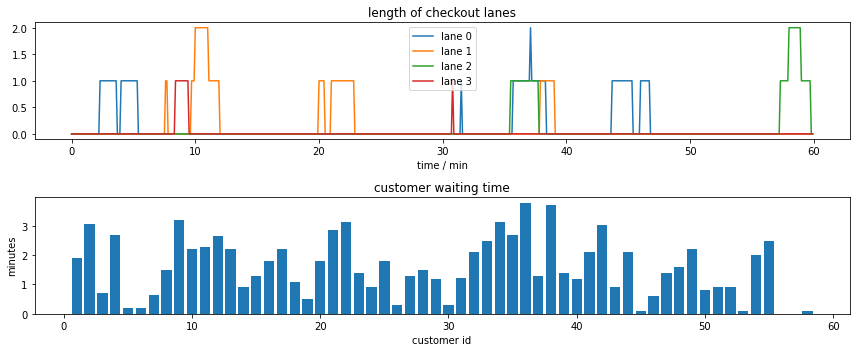

In [71]:
# time units = minutes

# number of checkout lanes
N = 4

# customer generator, assign to random checkout lane
def customer_generator(rate=1.0):
    customer_id = 1
    while True:
        yield env.timeout(random.expovariate(rate))
        n_cart_items = random.randint(1, 25)
        lane_number = random.randint(0, N-1)
        yield lanes[lane_number].put([customer_id, n_cart_items, env.now])
        customer_id += 1

# create a server for a specified check out lane
def checkout(lane, t_item = 1/10):
    while True:
        customer_id, n_cart_items, enter_time = yield lane.get()
        yield env.timeout(n_cart_items*t_item)
        customer_log.append([customer_id, n_cart_items, enter_time, env.now])
        
def lane_logger(t_sample=0.1):
    while True:
        lane_log.append([env.now] + [len(lane.items) for lane in lanes])
        yield env.timeout(t_sample)

# create simulation
lane_log = []
customer_log = []
env = simpy.Environment()

# checkout lanes modeled as SimPy Stores
lanes = [simpy.Store(env) for n in range(N)]

# create processes
env.process(customer_generator())
env.process(lane_logger())
for n in range(N):
    env.process(checkout(lanes[n]))

# run simulation
env.run(until=60)

# extract lane data
lane_df = pd.DataFrame(lane_log, columns = ["time"] + [f"lane {n}" for n in range(0, N)])
lane_df = lane_df.set_index("time")

customer_df = pd.DataFrame(customer_log, columns = ["customer id", "cart items", "enter", "leave"])
customer_df["elapsed"] = customer_df["leave"] - customer_df["enter"]

# plot results
fig, ax = plt.subplots(2, 1, figsize=(12, 5))
ax[0].plot(lane_df)
ax[0].set_xlabel("time / min")
ax[0].set_title("length of checkout lanes")
ax[0].legend(lane_df.columns)

ax[1].bar(customer_df["customer id"], customer_df["elapsed"])
ax[1].set_xlabel("customer id")
ax[1].set_ylabel("minutes")
ax[1].set_title("customer waiting time")
plt.tight_layout()

## Discussion questions to explore and answer.

For the next class session, please review and do as many of the following exercises as possible and submit your responses via Sakai. You can earn up to five points (1 point per item, up to a max of 5).

1. The default values for the model are 4 lanes, 1 new customer each minute, up to 25 items per cart, and each checkout server can process 10 items per minute. Rerun the simulation to determine the minimum number of lanes required for a stationary behavior. For this purpose, you may find it useful to extend the simulation from 60 minutes to a longer horizon.

2. Repeat the first exercise, but this time leave 4 lanes, and determine the maximum rate of customers that can be accommodated with stationary behavior.  

This model has incorporated a number of unrealistic assumptions. Let's attempt to fix aa few of them. Copy and paste the model into a new cell, and make the following modifications. Report the results of these modifications.

3. The time required for at the checkout counter is currently proportional to the number of items in the cart. A more realistic model would also include the additional time required for payment. Add a `t_payment` parameter to the checkout model with a default value of 2 minutes. Incorporate that time into the model. 

4. In the current model, are assumed to randomly select a lane. A more realistic behavior is for customers to select the shortest lane. Modify `customer_generator` to assign to the customer to the shortest lane. For this, you will need to access the length of each lane. For example, `len(lanes[0].items)` will return the length of lane 0.

5. The current plots report the total amount from when a customer enters the lane to the time the customer leaves the checkout. But what customers really care about is the time spent waiting to get to the checkout. Modify the customer data logging to collect the waiting time, construct a plot of the waiting time for each customer, and report the averate waiting time and length of each queue.
    
6. Someone has suggested changing two of the lanes to self-checkout. But a side effect of self-checkout is to increase the amount of time required to scan each item in a cart. Suppose the scan time goes from 6 seconds to 12 seconds for typical, untrained customers. Will additional attended lanes be required to offset the effect of slower scanning in the self-checkout lanes? If so, how many additional lanes will be required?

7. Suppose we were to change one or more of the lanes to a express lanes which handle only with a small number of items, say five or fewer. How would you expect this to change average waiting time? This is a form of prioritization ... are there other prioritizations that you might consider?

### Solution 1. 

>The default values for the model are 4 lanes, 1 new customer each minute, up to 25 items per cart, and each checkout server can process 10 items per minute. Rerun the simulation to determine the minimum number of lanes required for a stationary behavior. For this purpose, you may find it useful to extend the simulation from 60 minutes to a longer horizon.

* Increasing the solution horizon to 600 minutes helps detect non-stationary behavior.
* The number of checkout lanes is reduced by changing the value of N. 
    * N = 1 ==> non-stationary behavior evident in the increasing queue lengths
    * N = 2 ==> stationary behavior


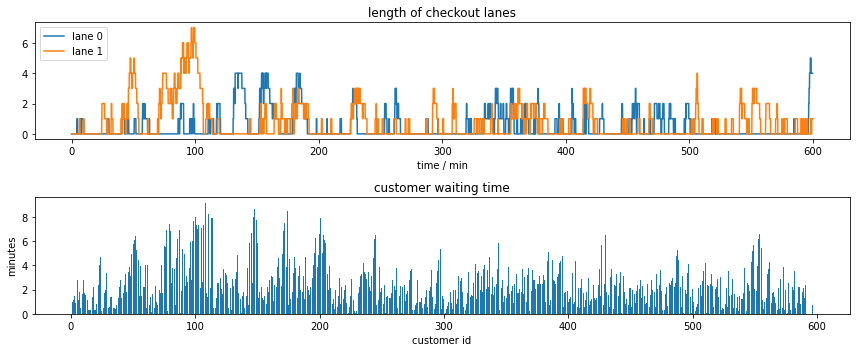

In [74]:
# time units = minutes

# number of checkout lanes
N = 2

# customer generator, assign to random checkout lane
def customer_generator(rate=1.0):
    customer_id = 1
    while True:
        yield env.timeout(random.expovariate(rate))
        n_cart_items = random.randint(1, 25)
        lane_number = random.randint(0, N-1)
        yield lanes[lane_number].put([customer_id, n_cart_items, env.now])
        customer_id += 1

# create a server for a specified check out lane
def checkout(lane, t_item = 1/10):
    while True:
        customer_id, n_cart_items, enter_time = yield lane.get()
        yield env.timeout(n_cart_items*t_item)
        customer_log.append([customer_id, n_cart_items, enter_time, env.now])
        
def lane_logger(t_sample=0.1):
    while True:
        lane_log.append([env.now] + [len(lane.items) for lane in lanes])
        yield env.timeout(t_sample)

# create simulation
lane_log = []
customer_log = []
env = simpy.Environment()

# checkout lanes modeled as SimPy Stores
lanes = [simpy.Store(env) for n in range(N)]

# create processes
env.process(customer_generator())
env.process(lane_logger())
for n in range(N):
    env.process(checkout(lanes[n]))

# run simulation
env.run(until=600)

# extract lane data
lane_df = pd.DataFrame(lane_log, columns = ["time"] + [f"lane {n}" for n in range(0, N)])
lane_df = lane_df.set_index("time")

customer_df = pd.DataFrame(customer_log, columns = ["customer id", "cart items", "enter", "leave"])
customer_df["elapsed"] = customer_df["leave"] - customer_df["enter"]

# plot results
fig, ax = plt.subplots(2, 1, figsize=(12, 5))
ax[0].plot(lane_df)
ax[0].set_xlabel("time / min")
ax[0].set_title("length of checkout lanes")
ax[0].legend(lane_df.columns)

ax[1].bar(customer_df["customer id"], customer_df["elapsed"])
ax[1].set_xlabel("customer id")
ax[1].set_ylabel("minutes")
ax[1].set_title("customer waiting time")
plt.tight_layout()

### Solution 2. 

>Repeat the first exercise, but this time leave 4 lanes, and determine the maximum rate of customers that can be accommodated with stationary behavior. 

### Solution 3. 

> The time required for at the checkout counter is currently proportional to the number of items in the cart. A more realistic model would also include the additional time required for payment. Add a `t_payment` parameter to the checkout model with a default value of 2 minutes. Incorporate that time into the model. 

4. In the current model, are assumed to randomly select a lane. A more realistic behavior is for customers to select the shortest lane. Modify `customer_generator` to assign to the customer to the shortest lane. For this, you will need to access the length of each lane. For example, `len(lanes[0].items)` will return the length of lane 0.

5. The current plots report the total amount from when a customer enters the lane to the time the customer leaves the checkout. But what customers really care about is the time spent waiting to get to the checkout. Modify the customer data logging to collect the waiting time, construct a plot of the waiting time for each customer, and report the averate waiting time and length of each queue.
    
6. Someone has suggested changing two of the lanes to self-checkout. But a side effect of self-checkout is to increase the amount of time required to scan each item in a cart. Suppose the scan time goes from 6 seconds to 12 seconds for typical, untrained customers. Will additional attended lanes be required to offset the effect of slower scanning in the self-checkout lanes? If so, how many additional lanes will be required?

7. Suppose we were to change one or more of the lanes to a express lanes which handle only with a small number of items, say five or fewer. How would you expect this to change average waiting time? This is a form of prioritization ... are there other prioritizations that you might consider?



### Solution 4. 

>


### Solution 5. 

>


### Solution 6. 

>


### Solution 7. 

>
